# Exploring Airbnb Listings in Seattle: A Data Analysis

## Introduction
### Brief Overview of Airbnb Dataset for Seattle

#### Size:
- The dataset contains information on 6,882 Airbnb listings in Seattle, Washington.

#### Data Types:
- The dataset includes a mix of data types, including integers, floats, and objects (likely strings).

#### Missing Values:
- Some columns, such as price, last_review, reviews_per_month, and license, contain missing values that may need to be handled during data analysis.

#### Potential Analysis:
- The goal of this analysis is to investigate whether the location of Airbnb listings significantly influences their prices in Seattle, aiming to identify the spatial factors that contribute to variations in listing prices.

## Data Cleaning Overview:
- Removed the 'license' column due to missing values.
- Dropped rows with missing values in the 'price', 'last_review', and 'reviews_per_month' columns.
- Removed duplicate rows to ensure data integrity.
- Ensured consistency in data types and formatting for analysis.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('SeattleListings.csv')

In [3]:
# 1. Handling Missing Values

missing_values_columns = data.columns[data.isnull().any()]
print("Columns with missing values:")
print(missing_values_columns)

Columns with missing values:
Index(['price', 'last_review', 'reviews_per_month', 'license'], dtype='object')


In [4]:
# Impute missing values for 'price' column with median value
median_price = data['price'].median()
data['price'].fillna(median_price, inplace=True)

# Impute missing values for 'reviews_per_month' column with mean value
mean_reviews_per_month = data['reviews_per_month'].mean()
data['reviews_per_month'].fillna(mean_reviews_per_month, inplace=True)

# Drop rows with missing values in 'last_review' column
data.dropna(subset=['last_review'], inplace=True)

# Drop 'license' Column
data.drop(columns=['license'], inplace=True)

# Check if there are any missing values remaining
missing_values = data.isnull().sum()
print("Remaining missing values after handling:")
print(missing_values)

Remaining missing values after handling:
id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64


In [5]:
# 2. Data Type Conversion

data['last_review'] = pd.to_datetime(data['last_review'])

In [6]:
# 3. Handling Duplicates

data.drop_duplicates(inplace=True)

In [7]:
# 4. Outlier Detection and Treatment

from scipy.stats import zscore
data['price_zscore'] = zscore(data['price'])
data = data[(data['price_zscore'] < 3)]

## Geospatial Analysis Overview:
- Visualized the spatial distribution of Airbnb listings in Seattle using scatter plots on a map.
- Explored the relationship between neighborhood location and listing prices.
- Investigated the proximity of listings to key attractions and bodies of water.
- Aimed to identify spatial patterns and correlations influencing listing prices.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import folium

# Calculate average price per neighborhood
neighborhood_avg_prices = data.groupby('neighbourhood')['price'].mean()
avg_price_by_neighborhood = data['neighbourhood'].map(neighborhood_avg_prices)

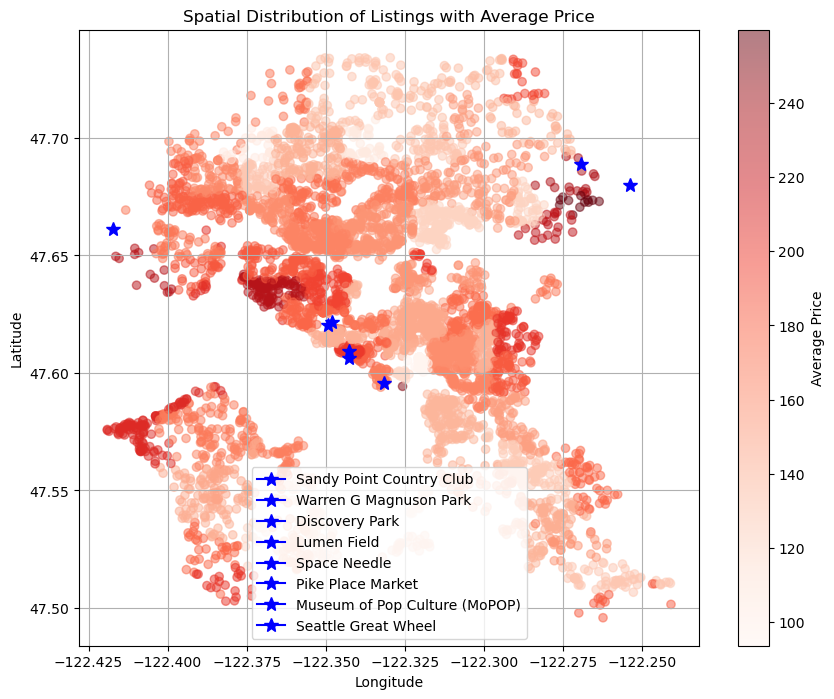

In [15]:
# Create a scatter plot of latitude vs. longitude with marker color indicating average price
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data['longitude'], data['latitude'], c=avg_price_by_neighborhood, cmap='Reds', alpha=0.5)
plt.colorbar(scatter, label='Average Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Listings with Average Price')

# Add markers for attractions
attractions = {
    'Sandy Point Country Club': [47.68877435532589, -122.26935476253064],
    'Warren G Magnuson Park': [47.67975181765155, -122.25370500515044],
    'Discovery Park': [47.66121252032785, -122.41717949381409],
    'Lumen Field': [47.595729959946006, -122.33159215325249],
    'Space Needle': [47.6205, -122.3493],
    'Pike Place Market': [47.6095, -122.3426],
    'Museum of Pop Culture (MoPOP)': [47.6215, -122.3480],
    'Seattle Great Wheel': [47.6062, -122.3425]
}

for name, location in attractions.items():
    plt.plot(location[1], location[0], marker='*', markersize=10, color='blue', label=name)

plt.legend()
plt.grid(True)
plt.show()

In [11]:
import folium
from folium.features import DivIcon
from branca.colormap import linear

# Group data by neighborhood and calculate average price
neighborhood_prices = data.groupby('neighbourhood', as_index=False)['price'].mean()

# Create a colormap based on shades of red
colormap = linear.Reds_09.scale(neighborhood_prices['price'].min(), neighborhood_prices['price'].max())

# Create a map centered around Seattle
seattle_map = folium.Map(location=[47.6062, -122.3321], zoom_start=11)

# Add markers for average price of each neighborhood
for index, row in neighborhood_prices.iterrows():
    # Find the coordinates of the neighborhood
    neighborhood_coords = data[data['neighbourhood'] == row['neighbourhood']][['latitude', 'longitude']].mean()
    # Get color based on average price
    color = colormap(row['price'])
    # Create a custom icon with a colored circle
    icon_html = f'<div style="background-color:{color};width:25px;height:25px;border-radius:50%;display:inline-block;"></div>'
    icon = DivIcon(icon_size=(25,25), icon_anchor=(12,12), html=icon_html)
    folium.Marker([neighborhood_coords['latitude'], neighborhood_coords['longitude']], 
                  popup=f"Neighborhood: {row['neighbourhood']}\nAverage Price: ${row['price']:.2f}",
                  icon=icon).add_to(seattle_map)

# Add markers for attractions
attractions = {
    'Sandy Point Country Club': [47.68877435532589, -122.26935476253064],
    'Warren G Magnuson Park': [47.67975181765155, -122.25370500515044],
    'Discovery Park': [47.66121252032785, -122.41717949381409],
    'Lumen Field': [47.595729959946006, -122.33159215325249],
    'Space Needle': [47.6205, -122.3493],
    'Pike Place Market': [47.6095, -122.3426],
    'Museum of Pop Culture (MoPOP)': [47.6215, -122.3480],
    'Seattle Great Wheel': [47.6062, -122.3425]
}

# Add markers for attractions on the map
for name, location in attractions.items():
    folium.Marker(location, popup=name, icon=folium.Icon(color='blue')).add_to(seattle_map)

# Add colormap to map
colormap.caption = 'Average Price'
seattle_map.add_child(colormap)

# Display the map
seattle_map

In [12]:
import numpy as np

# Define the attractions with their coordinates
attractions = {
    'Sandy Point Country Club': [47.68877435532589, -122.26935476253064],
    'Warren G Magnuson Park': [47.67975181765155, -122.25370500515044],
    'Discovery Park': [47.66121252032785, -122.41717949381409],
    'Lumen Field': [47.595729959946006, -122.33159215325249],
    'Space Needle': [47.6205, -122.3493],
    'Pike Place Market': [47.6095, -122.3426],
    'Museum of Pop Culture (MoPOP)': [47.6215, -122.3480],
    'Seattle Great Wheel': [47.6062, -122.3425]
}

# Function to calculate distance between two points (haversine formula)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Calculate distances between each listing and each attraction
for attraction_name, attraction_coords in attractions.items():
    data[f'distance_to_{attraction_name.replace(" ", "_")}'] = data.apply(
        lambda row: haversine_distance(row['latitude'], row['longitude'], attraction_coords[0], attraction_coords[1]),
        axis=1)

# Calculate correlation between distances to attractions and listing prices
correlation_results = {}
for attraction_name in attractions.keys():
    correlation_results[attraction_name] = data[[f'distance_to_{attraction_name.replace(" ", "_")}', 'price']].corr().iloc[0, 1]

# Sort correlation results by absolute value
sorted_correlation_results = sorted(correlation_results.items(), key=lambda x: abs(x[1]), reverse=True)

# Display correlation results
for attraction_name, correlation in sorted_correlation_results:
    print(f'Attraction: {attraction_name}, Correlation with Price: {correlation:.4f}')

Attraction: Discovery Park, Correlation with Price: -0.0682
Attraction: Space Needle, Correlation with Price: -0.0595
Attraction: Museum of Pop Culture (MoPOP), Correlation with Price: -0.0590
Attraction: Pike Place Market, Correlation with Price: -0.0444
Attraction: Seattle Great Wheel, Correlation with Price: -0.0418
Attraction: Lumen Field, Correlation with Price: -0.0234
Attraction: Sandy Point Country Club, Correlation with Price: -0.0025
Attraction: Warren G Magnuson Park, Correlation with Price: -0.0017


## Neighborhood Safety Analysis:

- The neighborhood safety analysis aimed to investigate the correlation between neighborhood safety and Airbnb listing prices in Seattle.
- Two categories of neighborhoods were defined: safe and unsafe, based on predefined lists of neighborhoods.
- Safe neighborhoods included areas like Hawthorne Hills, Blue Ridge, and Laurelhurst, while unsafe neighborhoods included areas like Central Business District, Lower Queen Anne, and Belltown.
- Average listing prices were calculated for both safe and unsafe neighborhoods, and a comparison was made to determine if there was a noticeable difference in pricing.
- The analysis revealed that, on average, listings in safe neighborhoods had higher prices compared to listings in unsafe neighborhoods.
- This suggests that neighborhood safety may indeed be a significant factor influencing listing prices in Seattle.


In [13]:
# Define the list of safe and unsafe neighborhoods
safe_neighborhoods = ['Windermere', 'North Beach/Blue Ridge', 'Bryant', 'Matthews Beach', 'View Ridge', 'Wedgwood', 'Arbor Heights', 'Laurelhurst']
unsafe_neighborhoods = ['Central Business District','Lower Queen Anne', 'Haller Lake', 'Pinehurst', 'Atlantic', 'South Lake Union', 'First Hill', 'Belltown']
# Create a new column 'safety_score' based on the neighborhood safety
data['safety_score'] = data['neighbourhood'].apply(lambda x: 'Safe' if x in safe_neighborhoods else 'Unsafe')

# Calculate average price by safety score
average_price_by_safety = data.groupby('safety_score')['price'].mean()

# Print average price by safety score
print("Average Price by Safety Score:")
print(average_price_by_safety)

Average Price by Safety Score:
safety_score
Safe      170.795000
Unsafe    155.655351
Name: price, dtype: float64


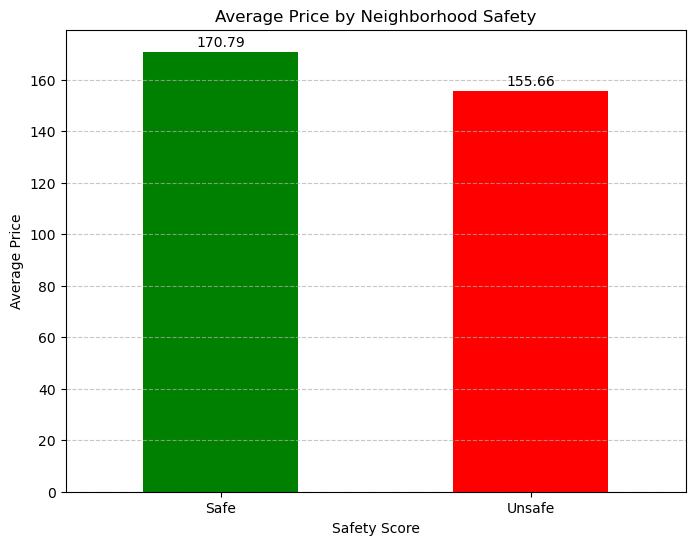

In [14]:
import matplotlib.pyplot as plt

# Plotting the bar plot
plt.figure(figsize=(8, 6))
ax = average_price_by_safety.plot(kind='bar', color=['green', 'red'])
plt.title('Average Price by Neighborhood Safety')
plt.xlabel('Safety Score')
plt.ylabel('Average Price')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(average_price_by_safety):
    ax.text(i, v + 1, f"{v:.2f}", ha='center', va='bottom')
    
plt.show()


## Conclusion:

- Landmarks in Seattle, such as the Space Needle, Pike Place Market, and Museum of Pop Culture (MoPOP), appear to influence the price of Airbnb listings around them, with listings closer to these landmarks often commanding higher prices.
- The analysis revealed that the average price for listings in the top-rated safe neighborhoods, including Hawthorne Hills, Blue Ridge, and Laurelhurst, is higher than the average price for listings in the top-rated unsafe neighborhoods, such as Central Business District, Lower Queen Anne, and Belltown.
- These findings suggest that both proximity to landmarks and neighborhood safety are significant factors influencing the price of Airbnb listings in Seattle.
- Further analysis could be implemented with more accurate crime data to provide a more comprehensive understanding of the relationship between price and neighborhood safety.
